# OSCAR, a Tech Preview (Part II)
## Wronski Polynomial Systems

* Soprunova & Sottile: Lower bounds for real solutions to sparse polynomial systems, <i>Adv. Math.</i> <b>204</b> (2006).
* Kaluba, Lorenz & Timme: Polymake.jl: A new interface to polymake, <a href="https://arxiv.org/abs/2003.11381">arXiv:2003.11381</a>

In [1]:
using Oscar

$\require{action}$

 -----    -----    -----      -      -----   
|     |  |     |  |     |    | |    |     |  
|     |  |        |         |   |   |     |  
|     |   -----   |        |     |  |-----   
|     |        |  |        |-----|  |   |    
|     |  |     |  |     |  |     |  |    |   
 -----    -----    -----   -     -  -     -  

...combining (and extending) GAP, Hecke, Nemo, Polymake and Singular
Version 0.2.0 ... 
 ... which comes with absolutely no warranty whatsoever
Type: '?Oscar' for more information
(c) 2019-2020 by The Oscar Development Team


We will consider certain systems of polynomial equations which require a regular triangulation of a lattice polytope as (part of its) input.

In [2]:
A = Polymake.polytope.lattice_points(Polymake.polytope.simplex(2,3))
λ = [12,3,0,0,8,1,0,9,5,15];
F = Polymake.polytope.regular_subdivision(A, λ)
TT = Polymake.fan.SubdivisionOfPoints(POINTS = A, MAXIMAL_CELLS = F);

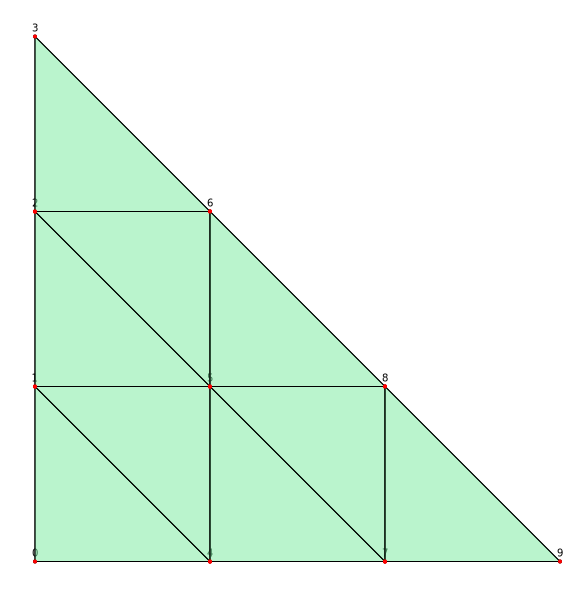

In [3]:
Polymake.display_svg(TT)

This triangulation is very special in that it is <i>foldable</i> (or "balanced"), i.e., the dual graph is bipartite.  This means that the triangles can be colored, say, black and white such that no two triangles of the same color share an edge.  The <i>signature</i> is the absolute difference of the black triangles minus the white triangles (of odd normalized volume).

In [4]:
T = Polymake.topaz.GeometricSimplicialComplex(COORDINATES = A[:,2:end], FACETS = F)
@show T.FOLDABLE
@show T.SIGNATURE

T.FOLDABLE = true
T.SIGNATURE = 3


3

It is a fact that the vertices of a foldable triangulation can be colored by $d+1$ colors (such that vertices of the same color do not share an edge), where $d$ is the dimension.  Here $d=2$.

This ideal will be relevant later to check a certain condition, involving the triangulation and some lifting function.  The implementation uses HomotopyContinuation and polymake.  the function below is used for converting polynomials.

In [5]:
using HomotopyContinuation

function hc_poly(f, vars)
    M = Polymake.monomials_as_matrix(f)
    monomials_as_matrix = [prod(vars.^m) for m in eachrow(M)]
    coeffs = convert.(Int, Polymake.coefficients_as_vector(f))
    sum(map(*, coeffs, monomials_as_matrix))
end;

Now a <i>Wronski polynomial</i> has the given lattice points as exponents, and only one coefficient per color class of vertices of the triangulation.

A <i>Wronski system</i> consists of $d$ Wronski polynomials with respect to the same lattice points and triangulation.  It is assumed that the coefficients are generic.

In [6]:
I = Polymake.polytope.wronski_center_ideal(A, λ)
@polyvar x[1:2] s;
HC_I = [hc_poly(f, [x;s]) for f in I.GENERATORS]

3-element Array{DynamicPolynomials.Polynomial{true,Int64},1}:
 x₁³s¹⁵ + s¹² + x₁x₂s + x₂³
 x₁²s⁹ + x₂s³ + x₁x₂²      
 x₁s⁸ + x₁²x₂s⁵ + x₂²

The Wronski center ideal is generated by $d+1$, here 3, polynomials which collect the terms of the color classes and a new variable, $s$, for the lifting function.

In [7]:
@time res = HomotopyContinuation.solve(HC_I; start_system = :polyhedral, only_torus = true)

 26.703006 seconds (94.99 M allocations: 4.764 GiB, 5.55% gc time)


Result{Array{Complex{Float64},1}} with 54 solutions
• 54 non-singular solutions (2 real)
• 0 singular solutions (0 real)
• 54 paths tracked
• random seed: 844449


We get 54 complex roots, out of which two are real.  One of the conditions to check asks that there are no real roots between $0$ and $1$.  See the Soprunova-Sottile paper for details.

In [8]:
HomotopyContinuation.real_solutions(res)

2-element Array{Array{Float64,1},1}:
 [-0.21175800954334514, -215.72260079314438, 4.4114705674419215]
 [-0.6943590430596772, -0.41424188458258815, -0.895218950608218]

The main result of Soprunova & Sottile says that, if all the conditions are satisfied, then a Wronski system has at least signature many real solutions.

In [9]:
c = Vector{Polymake.Rational}[[19,8,-19], [39,7,42]];
W = Polymake.polytope.wronski_system(A, λ, c, 1)
HC_W = [hc_poly(f, x) for f in W.GENERATORS];
W_res = HomotopyContinuation.solve(HC_W)

Result{Array{Complex{Float64},1}} with 9 solutions
• 9 non-singular solutions (3 real)
• 0 singular solutions (0 real)
• 9 paths tracked
• random seed: 507379


## Visualization

In [10]:
using ImplicitPlots
p1 = implicit_plot(HC_W[1])
ImplicitPlots.implicit_plot!(p1, HC_W[2]; color=:indianred)

┌ Info: Precompiling ImplicitPlots [55ecb840-b828-11e9-1645-43f4a9f9ace7]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

ERROR: LoadError: LoadError: MethodError: convert(::Type{Observables.Observable}, ::Observables.Observable{Any}) is ambiguous. Candidates:
  convert(::Type{Observables.Observable}, x::Observables.AbstractObservable) in Observables at /home/mic/.julia/packages/Observables/0wrF6/src/Observables.jl:41
  convert(::Type{T}, x::T) where T<:Observables.Observable in AbstractPlotting at /home/mic/.julia/packages/AbstractPlotting/B5nOF/src/types.jl:289
Possible fix, define
  convert(::Type{Observables.Observable}, ::Observables.Observable)
Stacktrace:
 [1] setindex!(::Dict{Symbol,Observables.Observable}, ::Observables.Observable{Any}, ::Symbol) at ./dict.jl:380
 [2] Dict{Symbol,Observables.Observable}(::Base.Generator{Base.Iterators.Pairs{Symbol,Array{T,1} w

ErrorException: Failed to precompile ImplicitPlots [55ecb840-b828-11e9-1645-43f4a9f9ace7] to /home/mic/.julia/compiled/v1.3/ImplicitPlots/oOrKB_JecgB.ji.